In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import obspy
from obspy.clients.fdsn import Client
ap = Client('IRIS')
from matplotlib.colors import LogNorm
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth


from coolfunctions import *

In [2]:
import rasterio
from pathlib import Path
import geopandas as gpd
from pyproj import Proj
from netCDF4 import Dataset

from obspy.clients.fdsn import Client
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

In [3]:
# setting up a good stereographic projection reference
stere_proj = Proj('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')

In [4]:
# loading in ice speed data
with Dataset("Antarctica_ice_velocity_2019_2020_1km_v01.1.nc") as nc:
    speed_x = nc['x'][:]
    speed_y = nc['y'][:]
    speed_data = np.sqrt(nc['VX'][:]**2 + nc['VY'][:]**2)

In [5]:
# loading in background topography data
with rasterio.open('moa125_2014_hp1_v01.tif') as raster:
    img_x = np.linspace(raster.bounds.left, raster.bounds.right, raster.width)
    img_y = np.linspace(raster.bounds.top, raster.bounds.bottom, raster.height)
    img_data = raster.read(1)

## Downloading Data

In [6]:
# loading event catalogues 

PIG_aqual = get_events('PIG', plot=False)
PIG_all = get_events('PIG', quality=False, plot=False)
Mel = get_events('Melangé', plot=False)
Ton = get_events('Tongue', plot=False)

Number of events in region: 4
Number of events in region: 66
Number of events in region: 25
Number of events in region: 21


In [7]:
PIG_aqual

([-75.45, -75.5, -75.53, -75.45],
 [-102.34, -102.42, -101.79, -99.67],
 ['2016-01-03T04:57:50.000000Z',
  '2016-01-10T19:23:32.000000Z',
  '2016-01-17T02:02:02.000000Z',
  '2018-06-30T20:57:12.000000Z'],
 [2016.0915525114156,
  2016.1107305936073,
  2016.129908675799,
  2018.5821917808219],
 [3.68, 3.52, 3.63, 3.52])

In [8]:
# we will start with just LH stations, but if this is kind of terrible talk with Son about adding more
inv_LH2 = ap.get_stations(network='YT', station="SILY,DNTW,BYRD,MA01,UNGL,WAIS,WHIT,THUR", level='response', channel='LHZ,LHN,LHE', starttime=obspy.UTCDateTime(2010,1,1,1),
                      endtime = obspy.UTCDateTime(2024,1,1,1), maxlatitude=-63)
print(inv_LH2)

sta_lats2 = []
sta_lons2 = []
sta_names2 = []
sta_distances2 = []
for i in range(len(inv_LH2)):
    for j in range(len(inv_LH2[i])):
        sta_lats2.append(inv_LH2[i][j].latitude)
        sta_lons2.append(inv_LH2[i][j].longitude)
        sta_names2.append(f"{inv_LH2[i].code}.{inv_LH2[i][j].code}")
        sta_distances2.append(distance(-75.2, -100, inv_LH2[i][j].latitude, inv_LH2[i][j].longitude)) # from PIG
print('Number of stations:', len(sta_lats2))

stations_flat2 = []
networks_flat2 = []
for i in range(len(inv_LH2)):
    for j in range(len(inv_LH2[i])):
        stations_flat2.append(inv_LH2[i][j].code)
        networks_flat2.append(inv_LH2[i].code)

print(len(stations_flat2))
print(len(networks_flat2))

# sort out creation and termination dates for each station
obspy_date_format = '%Y-%m-%dT%H:%M:%S.%fZ'

station_starts2 = []
station_ends2 = []
station_baz2 = []
station_dist2 = []

for i in range(len(inv_LH2)):
    for j in range(len(inv_LH2[i])):
        
        startyear = int(datetime.strptime(str(inv_LH2[i][j].start_date), obspy_date_format).strftime('%Y'))
        startmonth = int(datetime.strptime(str(inv_LH2[i][j].start_date), obspy_date_format).strftime('%m'))
        startday = int(datetime.strptime(str(inv_LH2[i][j].start_date), obspy_date_format).strftime('%d'))

        baz = gps2dist_azimuth(inv_LH2[i][j].latitude, inv_LH2[i][j].longitude, -75.5, -107)[2] # somewhere in the middle of the Thwaites Glacier area
        dist = gps2dist_azimuth(inv_LH2[i][j].latitude, inv_LH2[i][j].longitude, -75.5, -107)[0]/1000

        if inv_LH2[i][j].end_date == None:
            endyear = 2025
            endmonth = 1
            endday = 1
        else:
            endyear = int(datetime.strptime(str(inv_LH2[i][j].end_date), obspy_date_format).strftime('%Y'))
            endmonth = int(datetime.strptime(str(inv_LH2[i][j].end_date), obspy_date_format).strftime('%m'))
            endday = int(datetime.strptime(str(inv_LH2[i][j].end_date), obspy_date_format).strftime('%d'))

        station_starts2.append(startyear + startmonth/12 + startday/365)
        station_ends2.append(endyear + endmonth/12 + endday/365)
        station_baz2.append(baz)
        station_dist2.append(dist)

print('Station end dates length:', len(station_ends2))

Inventory created at 2025-10-23T01:29:34.140300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2010-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (8):
			YT.BYRD (BYRD)
			YT.DNTW (Lower Thwaites Glacier)
			YT.MA01 (Polenet mini-array MA01)
			YT.SILY (SILY)
			YT.THUR (Thurston Island)
			YT.UNGL (Union Glacier)
			YT.WAIS (WAIS)
			YT.WHIT (Whitmore Mountains)
		Channels (90):
			YT.BYRD..LHZ (5x), YT.BYRD..LHN (5x), YT.BYRD..LHE (5x), 
			YT.DNTW..LHZ (5x), YT.DNTW..LHN (5x), YT.DNTW..LHE (5x), 
			YT.MA01..LHZ, YT.MA01..LHN, YT.MA01..LHE, YT.SILY..LHZ (3x), 
			YT.SILY..LHN (3x), YT.SILY..LHE (3x), YT.THUR..LHZ (3x), 
			YT.THUR..LHN (3x), YT.THUR..LHE (3x), YT.UNGL..LHZ (5x), 
			YT.UNGL..LHN (5x), YT.UNGL..LHE (5x), YT.WAIS..LHZ (4x), 
			YT.WAIS..LHN (4x), YT.WAIS..LHE (4x), YT.WHIT..LHZ (4x), 
			YT.WHIT..LHN (4x), YT.WHIT..LHE (4x)
Number of stations

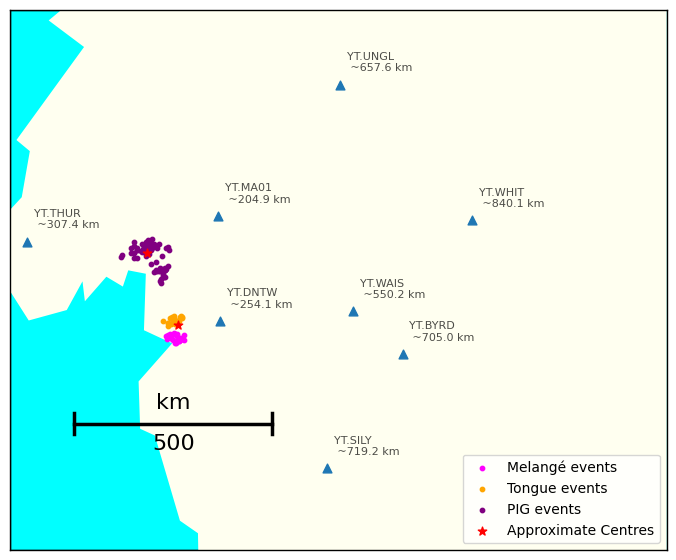

In [9]:

urcrnrlonc, urcrnrlatc = -40, -86 # upper right corner
llcrnrlonc, llcrnrlatc = -118, -70 # lower left corner

fig = plt.figure(figsize=(9, 6))
xa = fig.add_axes([0.90, 0.90, 0.90, 0.90])

ma = Basemap(epsg='3031', llcrnrlon=llcrnrlonc, llcrnrlat=llcrnrlatc, urcrnrlon=urcrnrlonc, urcrnrlat=urcrnrlatc, ax=xa)
wa, ha = ma.xmax, ma.ymax

ma.drawmapboundary(fill_color='aqua')
ma.fillcontinents(color='ivory', lake_color='aqua')

mel_events = ma.scatter(Mel[1], Mel[0], s=10, marker='o', color='magenta', latlon=True, label='Melangé events')
ton_events = ma.scatter(Ton[1], Ton[0], s=10, marker='o', color='orange', latlon=True, label='Tongue events')
pig_events = ma.scatter(PIG_all[1], PIG_all[0], s=10, marker='o', color='purple', latlon=True, label='PIG events')

centre_marker = ma.scatter(-107, -75.5, s=40, marker='*', color='red', latlon=True, label='Approximate Centres') # marking the centre of the map
PIG_marker = ma.scatter(-100, -75.2, s=40, marker='*', color='red', latlon=True) # marking the PIG region

son = ma.scatter(sta_lons2, sta_lats2, s=40, marker='^', latlon=True)

ma.drawmapscale(*(-115, -74.6), *(-115, -74.6), length=500, units='km', fontsize=16, zorder=2, linewidth=2.5)


# Add labels for each station
for i, (lon, lat, name, distancey) in enumerate(zip(sta_lons2, sta_lats2, sta_names2, sta_distances2)):
    x, y = ma(lon, lat)  # Convert lat/lon to map coordinates
    plt.annotate(text=f'{name} \n ~{distancey/1000:.1f} km', xy=(x, y), xytext=(5, 8), textcoords='offset points',
                fontsize=8, ha='left', va='bottom', alpha=0.7)

plt.legend(loc='lower right', fontsize=10)

plt.show()

In [10]:
def filter_and_trime(stream, freqmin=0.01, freqmax=0.1):
    stream_filtered = stream.copy()
    stream_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    for tr in stream_filtered:
        tr.trim(starttime=tr.stats.starttime + 200, endtime=tr.stats.endtime - 200)
    return stream_filtered

In [11]:
# PIG_aqual_unfiltered = trace_searcher(0, 1000, PIG_aqual, inv_tot, channel='LHZ,LHN,LHE')
#     sta_lats, sta_lons, stations_flat, networks_flat, station_starts, station_ends, inv = station_info

inv2_tot = (sta_lats2, sta_lons2, stations_flat2, networks_flat2, station_starts2, station_ends2, inv_LH2)

# PIG_aqual_inv2_unfiltered = trace_searcher(0, 1000, PIG_aqual, inv2_tot, channel='LHZ')

import pickle

# with open('PIG_aqual_inv2_unfiltered.pkl', 'wb') as f:
#     pickle.dump(PIG_aqual_inv2_unfiltered, f)

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\SigsandSpecs\PIG_aqual_inv2_unfiltered.pkl", 'rb') as f:
    PIG_aqual_inv2_unfiltered = pickle.load(f)

In [12]:
# PIG_all_inv2_unfiltered = trace_searcher(0, 1000, PIG_all, inv2_tot, channel='LHZ')
# with open('PIG_all_inv2_unfiltered.pkl', 'wb') as f:
#     pickle.dump(PIG_all_inv2_unfiltered, f)

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\SigsandSpecs\PIG_all_inv2_unfiltered.pkl", 'rb') as f:
    PIG_all_inv2_unfiltered = pickle.load(f)

In [13]:
# Mel_inv2_unfiltered = trace_searcher(0, 1000, Mel, inv2_tot, channel='LHZ')
# with open('Mel_inv2_unfiltered.pkl', 'wb') as f:
#     pickle.dump(Mel_inv2_unfiltered, f)

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\SigsandSpecs\Mel_inv2_unfiltered.pkl", 'rb') as f:
    Mel_inv2_unfiltered = pickle.load(f)

In [14]:
# Ton_inv2_unfiltered = trace_searcher(0, 1000, Ton, inv2_tot, channel='LHZ')
# with open('Ton_inv2_unfiltered.pkl', 'wb') as f:
#     pickle.dump(Ton_inv2_unfiltered, f)

with open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\SigsandSpecs\Ton_inv2_unfiltered.pkl", 'rb') as f:
    Ton_inv2_unfiltered = pickle.load(f)

In [15]:
PIG_aqual_inv2_10_100 = filter_and_trime(PIG_aqual_inv2_unfiltered[0])
PIG_all_inv2_10_100 = filter_and_trime(PIG_all_inv2_unfiltered[0])
Mel_inv2_10_100 = filter_and_trime(Mel_inv2_unfiltered[0])
Ton_inv2_10_100 = filter_and_trime(Ton_inv2_unfiltered[0])

## Spectral Bulk Summary

In [16]:
def plot_fancy_norm_nontracey(traces, axes_dict=None, axlabel=True):
    '''
    plot of spectrogram, signal, and FFT, with normalised and unnormalised averages in place
    '''
    ## spectrogram bit
    fs = 1.0  # sampling rate in Hz
    nfft = 128  # number of points in FFT
    pad_to = 1024  # padding to next power of 2
    noverlap = 115  # number of points to overlap between segments
    vmin, vmax = 0.0, 1.0  # color scale limits

    # extracting the data
    datas = []
    datas_times = []
    for trace in traces:
        if len(trace.data) == 400:  # somewhat arbitrary - we expect 400 and can't use 128 or below lengths
            datas.append(trace.data)
            datas_times.append(trace.times())

    if len(datas) == 0:
        return None

    datas_max = max([max(data) for data in datas])
    datas_min = min([min(data) for data in datas])

    # Hilbert envelopes
    envelopes = []
    envelopes_max = []
    envelopes_norm = []
    for i in range(len(datas)):
        analytic_signal = hilbert(datas[i])
        envelope = np.abs(analytic_signal)
        envelopes_max.append(np.max(envelope))
        envelope_norm = envelope / np.max(envelope)  # normalising the envelope
        #envelopes.append(envelope)
        if np.any(np.isnan(envelope_norm)) == False and np.any(np.isinf(envelope_norm)) == False:
            envelopes.append(envelope)
            envelopes_norm.append(envelope_norm)

    # average signal
    average_signal = np.mean(envelopes, axis=0)
    average_signal_norm = np.mean(envelopes_norm, axis=0) * np.max(envelopes_max)
    
    # print('envelopes_norm contains NaN:', np.any(np.isnan(envelopes_norm)))
    # print('envelopes_norm contains inf:', np.any(np.isinf(envelopes_norm)))
    # print('max envelope:', [np.max(envelope) for envelope in envelopes])
    
    # doing the spectrogram calculation
    specs, freqs, times = [], [], []
    for data in datas:
        spec, freq, time = mlab.specgram(data, Fs=fs, NFFT=nfft, pad_to=pad_to, noverlap=noverlap)
        spec = np.sqrt(spec[1:, :])
        freq = freq[1:]
        halfbin_time = (time[1] - time[0]) / 2.0
        halfbin_freq = (freq[1] - freq[0]) / 2.0
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        time -= halfbin_time
        freq -= halfbin_freq
        
        if spec.min() != spec.max():
            specs.append(spec)
            freqs.append(freq)
            times.append(time)

    # for i, spec in enumerate(specs):
    #     print(f'Spec {i}: min={spec.min()}, max={spec.max()}')

    # making them all of equal size
    min_time_bins = min(spec.shape[1] for spec in specs)
    min_freq_bins = min(spec.shape[0] for spec in specs)
    for i in range(len(specs)):
        specs[i] = specs[i][:min_freq_bins, :min_time_bins]
        vmin = specs[i].min() + vmin * float(specs[i].max() - specs[i].min())
        vmax = specs[i].min() + vmax * float(specs[i].max() - specs[i].min())
        specs[i] = (specs[i] - specs[i].min()) / (specs[i].max() - specs[i].min())  # normalize

    avg_spec = np.mean(specs, axis=0)
    spectrogram_data = times[0][:min_time_bins], freqs[0][:min_freq_bins], avg_spec

    ## FFT bit
    spectrums = []
    ns = []
    fft_datas = []
    fft_datas_norm = []
    fft_max = []
    for i in range(len(datas)):
        fft = np.fft.fft(datas[i])
        fft_max.append(np.max(np.abs(fft)))
        fft_norm = fft / np.max(np.abs(fft))  # normalize
        nn = len(datas[i])
        if np.any(np.isnan(fft_norm)) == False and np.any(np.isinf(fft_norm)) == False:
            fft_datas.append(fft)
            fft_datas_norm.append(fft_norm)
            ns.append(nn)
            spectrums.append(np.fft.fftfreq(nn, 1))

    fft_average = np.mean(np.abs(fft_datas), axis=0)
    fft_average_norm = np.mean(np.abs(fft_datas_norm), axis=0) * np.max(fft_max)

    ## plotting - use provided axes or create new ones
    if axes_dict is None:
        # Create standalone figure
        fig = plt.figure(figsize=(7, 7))
        ax_sig = fig.add_axes([0.3, 0.1, 0.6, 0.2])
        ax_spec = fig.add_axes([0.3, 0.3, 0.6, 0.6])
        ax_fft = fig.add_axes([0.1, 0.3, 0.2, 0.6])
        standalone = True
    else:
        # Use provided axes from mosaic
        ax_sig = axes_dict['signal']
        ax_spec = axes_dict['spectrogram']
        ax_fft = axes_dict['fft']
        standalone = False

    signals_x_axis = np.linspace(-200, 200, len(datas_times[0]))

    # plot signals
    for i in range(len(datas)):
        ax_sig.plot(datas_times[i], datas[i], color='grey')
    ax_sig.plot(datas_times[0], average_signal, color='C0', linewidth=2, label='avg signal')
    ax_sig.plot(datas_times[0], average_signal_norm, color='C1', linewidth=2, label='avg norm signal')
    ax_sig.plot(datas_times[0][np.argmax(average_signal)], np.max(average_signal), 'or')
    ax_sig.plot(datas_times[0][np.argmax(average_signal_norm)], np.max(average_signal_norm), 'or')
    ax_sig.axvline(200, 0, 1, color='k', linewidth=2, alpha=0.7)
    ax_sig.set_xlabel('time (s)')

    # plot spectrogram
    x, y, data = spectrogram_data
    ax_spec.set_yscale('log')
    img_spec = ax_spec.pcolormesh(x, y, data, shading='gouraud')
    img_spec.set_rasterized(True)
    ax_spec.axvline(200, 0, 1, color='k', alpha=0.7, linewidth=2, label='expected arrival')
    ax_spec.axhline(0.04, 0, 1, color='skyblue', alpha=0.5, ls='--', linewidth=2, label='expected freq.')
    ax_spec.axhline(0.06, 0, 1, color='skyblue', alpha=0.5, ls='--', linewidth=2)

    # plot fft
    for i in range(len(spectrums)):
        ax_fft.semilogy(np.abs(fft_datas[i][:ns[i] // 2]), spectrums[i][:ns[i] // 2], color='grey')
    ax_fft.semilogy(np.abs(fft_average[:ns[0] // 2]), spectrums[0][:ns[0] // 2], color='C0', linewidth=2, label='average')
    ax_fft.semilogy(np.abs(fft_average_norm[:ns[0] // 2]), spectrums[0][:ns[0] // 2], color='C1', linewidth=2, label='norm. average\n(scaled)')
    ax_fft.plot(np.max(fft_average), spectrums[0][np.argmax(fft_average[:ns[0] // 2])], 'or')
    ax_fft.plot(np.max(fft_average_norm), spectrums[0][np.argmax(fft_average_norm[:ns[0] // 2])], 'or')
    ax_fft.axhline(0.04, 0, 1, color='skyblue', alpha=0.5, ls='--', linewidth=2)
    ax_fft.axhline(0.06, 0, 1, color='skyblue', alpha=0.5, ls='--', linewidth=2)
    if axlabel is True:
        ax_fft.set_ylabel('frequency (Hz)')
        leg = ax_fft.legend(bbox_to_anchor=(0.65, -0.1, 0.02, 0.01))

    ax_fft.invert_xaxis()

    # Set limits
    ax_spec.set_ylim(0.009, 0.2)
    ax_spec.set_xlim(x[0], x[-1])
    ax_sig.set_ylim(datas_min * 2.5, datas_max * 2.5)
    ax_sig.set_xlim(x[0], x[-1])
    ax_fft.set_ylim(0.009, 0.2)
    
    # Only format axes if standalone
    if standalone:
        from matplotlib.ticker import NullFormatter
        ax_spec.xaxis.set_major_formatter(NullFormatter())
        ax_spec.yaxis.set_major_formatter(NullFormatter())
        ax_fft.xaxis.set_major_formatter(NullFormatter())
        
        plt.show()

    return ax_sig, ax_spec, ax_fft

## Spectral Other Plots

In [17]:
PIG_aqual_inv2_10_100

30 Trace(s) in Stream:

YT.BYRD..LHZ | 2016-01-03T04:58:04.999998Z - 2016-01-03T05:04:43.999998Z | 1.0 Hz, 400 samples
...
(28 other traces)
...
YT.WHIT..LHZ | 2018-06-30T20:58:25.000000Z - 2018-06-30T21:05:04.000000Z | 1.0 Hz, 400 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

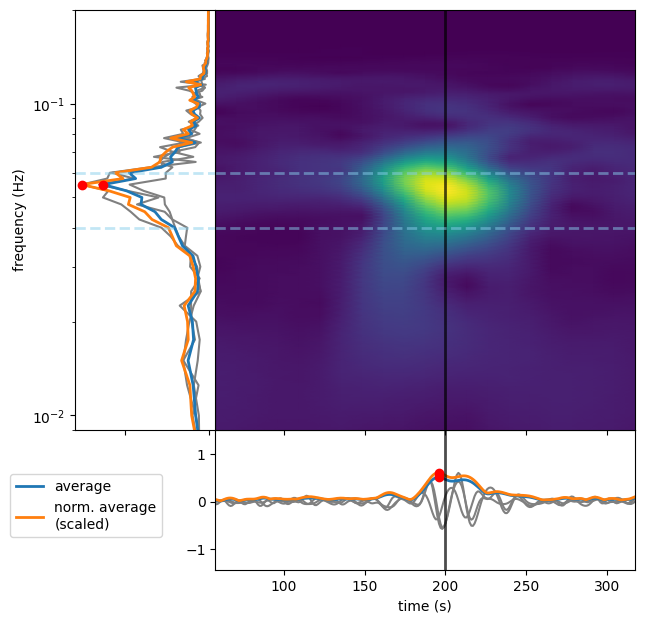

In [18]:
# separating to by stations
stations = list(set([tr.stats.station for tr in PIG_aqual_inv2_10_100]))

ssep_PIG_aqual = {station: PIG_aqual_inv2_10_100.select(station=station) for station in stations}
ssep_PIG_all = {station: PIG_all_inv2_10_100.select(station=station) for station in stations}
ssep_Mel = {station: Mel_inv2_10_100.select(station=station) for station in stations}
ssep_Ton = {station: Ton_inv2_10_100.select(station=station) for station in stations}

teste = plot_fancy_norm_nontracey(ssep_PIG_aqual['MA01'])

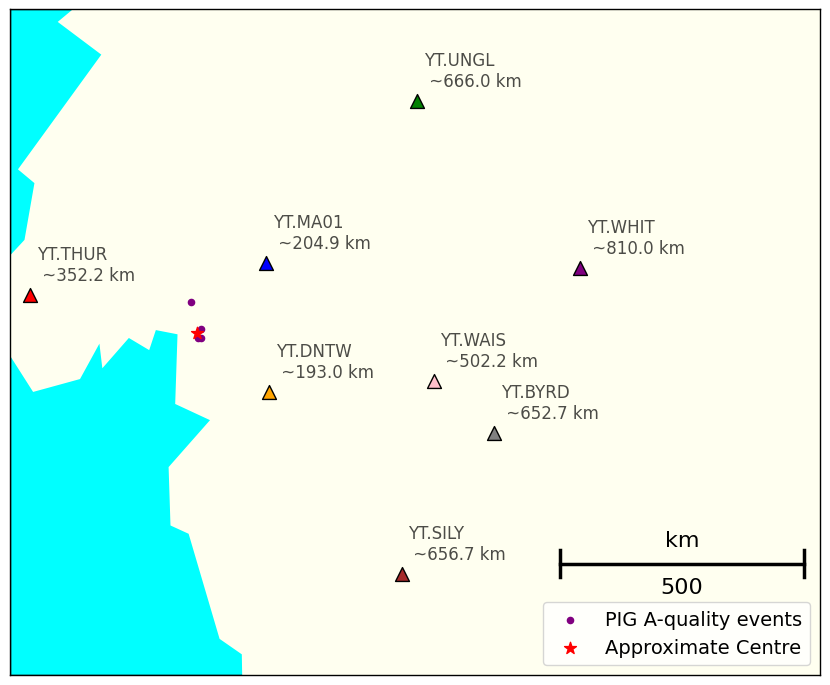

In [19]:
def shitty_map_plotter(dataset, ax=None):
    urcrnrlonc, urcrnrlatc = -40, -86 # upper right corner
    llcrnrlonc, llcrnrlatc = -118, -70 # lower left corner
    if ax is None:
        fig = plt.figure(figsize=(9,9))
        ax = fig.add_axes([0.90, 0.90, 0.90, 0.90])

    ma = Basemap(epsg='3031', llcrnrlon=llcrnrlonc, llcrnrlat=llcrnrlatc, urcrnrlon=urcrnrlonc, urcrnrlat=urcrnrlatc, ax=ax)
    wa, ha = ma.xmax, ma.ymax

    ma.drawmapboundary(fill_color='aqua')
    ma.fillcontinents(color='ivory', lake_color='aqua')
    
    if dataset == 'PIG_aqual':
        events = ma.scatter(PIG_aqual[1], PIG_aqual[0], s=20, marker='o', color='purple', latlon=True, label='PIG A-quality events')
        centre_coords = [-102, -75.44]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'PIG_all':
        events = ma.scatter(PIG_all[1], PIG_all[0], s=20, marker='o', color='purple', latlon=True, label='PIG all events')
        centre_coords = [-100, -75.2]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'Mel':
        events = ma.scatter(Mel[1], Mel[0], s=20, marker='o', color='magenta', latlon=True, label='Melangé events')
        centre_coords = [-107, -75.5]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'Ton':
        events = ma.scatter(Ton[1], Ton[0], s=20, marker='o', color='orange', latlon=True, label='Tongue events')
        centre_coords = [-107, -75.5]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 

    # station_cols = [          'red',      'blue',   'green',   'purple', 'orange',   'brown',    'pink',   'grey']
    #for i, ax in enumerate([THUR_spec, MA01_spec, UNGL_spec, WHIT_spec, DNTW_spec, SILY_spec, WAIS_spec, BYRD_spec]):
    station_cols = ['grey', 'orange', 'blue', 'brown', 'red', 'green', 'pink', 'purple']

    for i in range(len(sta_lons2)):
        ma.scatter(sta_lons2[i], sta_lats2[i], s=100, marker='^', color=station_cols[i], edgecolors='black', latlon=True)

    #son = ma.scatter(sta_lons2, sta_lats2, s=80, marker='^', latlon=True)
    ma.drawmapscale(*(-145, -81), *(-145, -81), length=500, units='km', fontsize=16, zorder=2, linewidth=2.5)
    
    for i, (lon, lat, name) in enumerate(zip(sta_lons2, sta_lats2, sta_names2)):
        x, y = ma(lon, lat)
        distance = gps2dist_azimuth(lat, lon, centre_coords[1], centre_coords[0])[0]
        baz = gps2dist_azimuth(lat, lon, centre_coords[1], centre_coords[0])[2]
        plt.annotate(text=f'{name} \n ~{distance/1000:.1f} km', xy=(x, y), xytext=(5, 8), textcoords='offset points',
                    fontsize=12, ha='left', va='bottom', alpha=0.7)
        
    plt.legend(loc='lower right', fontsize=14)
    
    if ax is None:
        plt.show()
        
    return ma
        
tester = shitty_map_plotter('PIG_aqual')

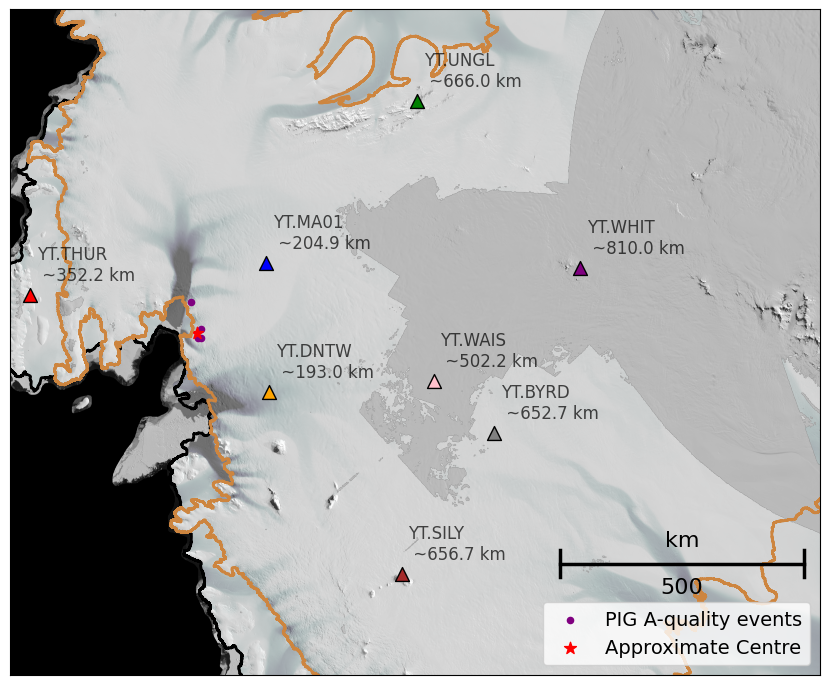

In [20]:
def good_map_plotter(dataset, ax=None):
    urcrnrlonc, urcrnrlatc = -40, -86 # upper right corner
    llcrnrlonc, llcrnrlatc = -118, -70 # lower left corner
    if ax is None:
        fig = plt.figure(figsize=(9,9))
        ax = fig.add_axes([0.90, 0.90, 0.90, 0.90])

    ma = Basemap(epsg='3031', llcrnrlon=llcrnrlonc, llcrnrlat=llcrnrlatc, urcrnrlon=urcrnrlonc, urcrnrlat=urcrnrlatc, ax=ax)
    wa, ha = ma.xmax, ma.ymax
    min_x, min_y = stere_proj(ma.llcrnrlon, ma.llcrnrlat)
    max_x, max_y = stere_proj(ma.urcrnrlon, ma.urcrnrlat)
    mask_x = (min_x <= img_x) & (img_x <= max_x)
    mask_y = (min_y <= img_y) & (img_y <= max_y)

    ma.readshapefile('Coastlines/moa2014_coastline_v01_wgs84', 'coastline', linewidth=2, zorder=2, color='k')
    ma.readshapefile('Groundinglines/moa2014_grounding_line_v01_wgs84', 'grounding', linewidth=2, zorder=2, color='peru')

    # background topographic image
    tmp = img_data[np.logical_and(min_y<=img_y, img_y<=max_y)][:, np.logical_and(min_x<=img_x, img_x<=max_x)]
    ma.imshow(tmp, cmap='gray', origin='upper', vmax=2.2e4)
    # ice velocity data
    tmp_c = speed_data[np.logical_and(min_y<=speed_y, speed_y<=max_y)][:, np.logical_and(min_x<=speed_x, speed_x<=max_x)]
    mappable_c = ma.imshow(tmp_c, cmap='bone_r', origin='upper', alpha=.4, vmin=0, vmax=1e3)

    # ma.drawmapboundary(fill_color='aqua')
    # ma.fillcontinents(color='ivory', lake_color='aqua')
    
    if dataset == 'PIG_aqual':
        events = ma.scatter(PIG_aqual[1], PIG_aqual[0], s=20, marker='o', color='purple', latlon=True, label='PIG A-quality events')
        centre_coords = [-102, -75.44]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'PIG_all':
        events = ma.scatter(PIG_all[1], PIG_all[0], s=20, marker='o', color='purple', latlon=True, label='PIG all events')
        centre_coords = [-100, -75.2]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'Mel':
        events = ma.scatter(Mel[1], Mel[0], s=20, marker='o', color='magenta', latlon=True, label='Mélange events')
        centre_coords = [-107, -75.5]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 
    if dataset == 'Ton':
        events = ma.scatter(Ton[1], Ton[0], s=20, marker='o', color='orange', latlon=True, label='Tongue events')
        centre_coords = [-107, -75.5]
        centre_marker = ma.scatter(*centre_coords, s=80, marker='*', color='red', latlon=True, label='Approximate Centre') 

    # station_cols = [          'red',      'blue',   'green',   'purple', 'orange',   'brown',    'pink',   'grey']
    #for i, ax in enumerate([THUR_spec, MA01_spec, UNGL_spec, WHIT_spec, DNTW_spec, SILY_spec, WAIS_spec, BYRD_spec]):
    station_cols = ['grey', 'orange', 'blue', 'brown', 'red', 'green', 'pink', 'purple']

    for i in range(len(sta_lons2)):
        ma.scatter(sta_lons2[i], sta_lats2[i], s=100, marker='^', color=station_cols[i], edgecolors='black', latlon=True)

    #son = ma.scatter(sta_lons2, sta_lats2, s=80, marker='^', latlon=True)
    ma.drawmapscale(*(-145, -81), *(-145, -81), length=500, units='km', fontsize=16, zorder=2, linewidth=2.5)
    
    for i, (lon, lat, name) in enumerate(zip(sta_lons2, sta_lats2, sta_names2)):
        x, y = ma(lon, lat)
        distance = gps2dist_azimuth(lat, lon, centre_coords[1], centre_coords[0])[0]
        baz = gps2dist_azimuth(lat, lon, centre_coords[1], centre_coords[0])[2]
        plt.annotate(text=f'{name} \n ~{distance/1000:.1f} km', xy=(x, y), xytext=(5, 8), textcoords='offset points',
                    fontsize=12, ha='left', va='bottom', alpha=0.7)
        
    plt.legend(loc='lower right', fontsize=14)
    
    if ax is None:
        plt.show()
        
    return ma
        
tester = good_map_plotter('PIG_aqual')

In [21]:
import matplotlib.gridspec as gridspec

def inv2_plotter(dataset, savefig=False):
    fig = plt.figure(figsize=(21, 16))
    main_gs = gridspec.GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 1], left=0.05, right=0.95, wspace=0.2, hspace=0.2)
    
    # map plot
    ax_map = fig.add_subplot(main_gs[0:2, 0:2])
    good_map_plotter(dataset, ax=ax_map)
    
    THUR_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[0, 2],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    MA01_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[0, 3],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    UNGL_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[1, 2],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    WHIT_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[1, 3],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    DNTW_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[2, 0],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    SILY_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[2, 1],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    WAIS_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[2, 2],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    BYRD_nested = gridspec.GridSpecFromSubplotSpec(2, 2, main_gs[2, 3],
                                                 height_ratios=[0.6, 0.2], width_ratios=[0.2, 0.6], hspace=0.01, wspace=0.01)
    
    THUR_fft = fig.add_subplot(THUR_nested[0, 0])      # Top-left (FFT)
    THUR_spec = fig.add_subplot(THUR_nested[0, 1])     # Top-right (Spectrogram)
    THUR_sig = fig.add_subplot(THUR_nested[1, 1])      # Bottom-right (Signal)
    MA01_fft = fig.add_subplot(MA01_nested[0, 0])      # Top-left (FFT)
    MA01_spec = fig.add_subplot(MA01_nested[0, 1])     # Top-right (Spectrogram)
    MA01_sig = fig.add_subplot(MA01_nested[1, 1])      # Bottom-right (Signal)
    UNGL_fft = fig.add_subplot(UNGL_nested[0, 0])      # Top-left (FFT)
    UNGL_spec = fig.add_subplot(UNGL_nested[0, 1])     # Top-right (Spectrogram)
    UNGL_sig = fig.add_subplot(UNGL_nested[1, 1])      # Bottom-right (Signal)
    WHIT_fft = fig.add_subplot(WHIT_nested[0, 0])      # Top-left (FFT)
    WHIT_spec = fig.add_subplot(WHIT_nested[0, 1])     # Top-right (Spectrogram)    
    WHIT_sig = fig.add_subplot(WHIT_nested[1, 1])      # Bottom-right (Signal)
    DNTW_fft = fig.add_subplot(DNTW_nested[0, 0])
    DNTW_spec = fig.add_subplot(DNTW_nested[0, 1])     # Top-right (Spectrogram)
    DNTW_sig = fig.add_subplot(DNTW_nested[1, 1])      # Bottom-right (Signal)
    SILY_fft = fig.add_subplot(SILY_nested[0, 0])      # Top-left (FFT)
    SILY_spec = fig.add_subplot(SILY_nested[0, 1])     # Top-right (Spectrogram)
    SILY_sig = fig.add_subplot(SILY_nested[1, 1])      # Bottom-right (Signal)
    WAIS_fft = fig.add_subplot(WAIS_nested[0, 0])      # Top-left (FFT)
    WAIS_spec = fig.add_subplot(WAIS_nested[0, 1])     # Top-right (Spectrogram)
    WAIS_sig = fig.add_subplot(WAIS_nested[1, 1])      # Bottom-right (Signal)
    BYRD_fft = fig.add_subplot(BYRD_nested[0, 0])      # Top-left (FFT)
    BYRD_spec = fig.add_subplot(BYRD_nested[0, 1])     # Top-right (Spectrogram)
    BYRD_sig = fig.add_subplot(BYRD_nested[1, 1])      # Bottom-right (Signal)
    
    if dataset == 'PIG_aqual':
        plot_data = ssep_PIG_aqual
    if dataset == 'PIG_all':
        plot_data = ssep_PIG_all
    if dataset == 'Mel':
        plot_data = ssep_Mel
    if dataset == 'Ton':
        plot_data = ssep_Ton
    
    plot_fancy_norm_nontracey(plot_data['THUR'], 
                            axes_dict={'fft': THUR_fft, 'spectrogram': THUR_spec, 'signal': THUR_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['MA01'],
                            axes_dict={'fft': MA01_fft, 'spectrogram': MA01_spec, 'signal': MA01_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['UNGL'],
                            axes_dict={'fft': UNGL_fft, 'spectrogram': UNGL_spec, 'signal': UNGL_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['WHIT'],
                            axes_dict={'fft': WHIT_fft, 'spectrogram': WHIT_spec, 'signal': WHIT_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['DNTW'],
                            axes_dict={'fft': DNTW_fft, 'spectrogram': DNTW_spec, 'signal': DNTW_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['SILY'],
                            axes_dict={'fft': SILY_fft, 'spectrogram': SILY_spec, 'signal': SILY_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['WAIS'],
                            axes_dict={'fft': WAIS_fft, 'spectrogram': WAIS_spec, 'signal': WAIS_sig}, axlabel=False)
    plot_fancy_norm_nontracey(plot_data['BYRD'],
                            axes_dict={'fft': BYRD_fft, 'spectrogram': BYRD_spec, 'signal': BYRD_sig}, axlabel=False)

    THUR_spec.set_title('YT.THUR', fontweight='bold')
    MA01_spec.set_title('YT.MA01', fontweight='bold')
    UNGL_spec.set_title('YT.UNGL', fontweight='bold')
    WHIT_spec.set_title('YT.WHIT', fontweight='bold')
    DNTW_spec.set_title('YT.DNTW', fontweight='bold')
    SILY_spec.set_title('YT.SILY', fontweight='bold')
    WAIS_spec.set_title('YT.WAIS', fontweight='bold')
    BYRD_spec.set_title('YT.BYRD', fontweight='bold')

    station_cols = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'grey']

    for i, ax in enumerate([THUR_spec, MA01_spec, UNGL_spec, WHIT_spec, DNTW_spec, SILY_spec, WAIS_spec, BYRD_spec]):
        for spine in ax.spines.values():
            spine.set_edgecolor(station_cols[i])
            spine.set_linewidth(3)
    
    if dataset == 'PIG_aqual':
        main_title = 'PIG A-quality data - 10-100s bandpass filtered'
    if dataset == 'PIG_all':
        main_title = 'PIG All data - 10-100s bandpass filtered'
    if dataset == 'Mel':
        main_title = 'Mélange data - 10-100s bandpass filtered'
    if dataset == 'Ton':
        main_title = 'Tongue data - 10-100s bandpass filtered'

    fig.suptitle(main_title, fontsize=28)
    fig.subplots_adjust(top=0.92)
    plt.show()
    if savefig:
        fig.savefig(f'inv2_plot_{dataset}.png', bbox_inches='tight')
    return fig

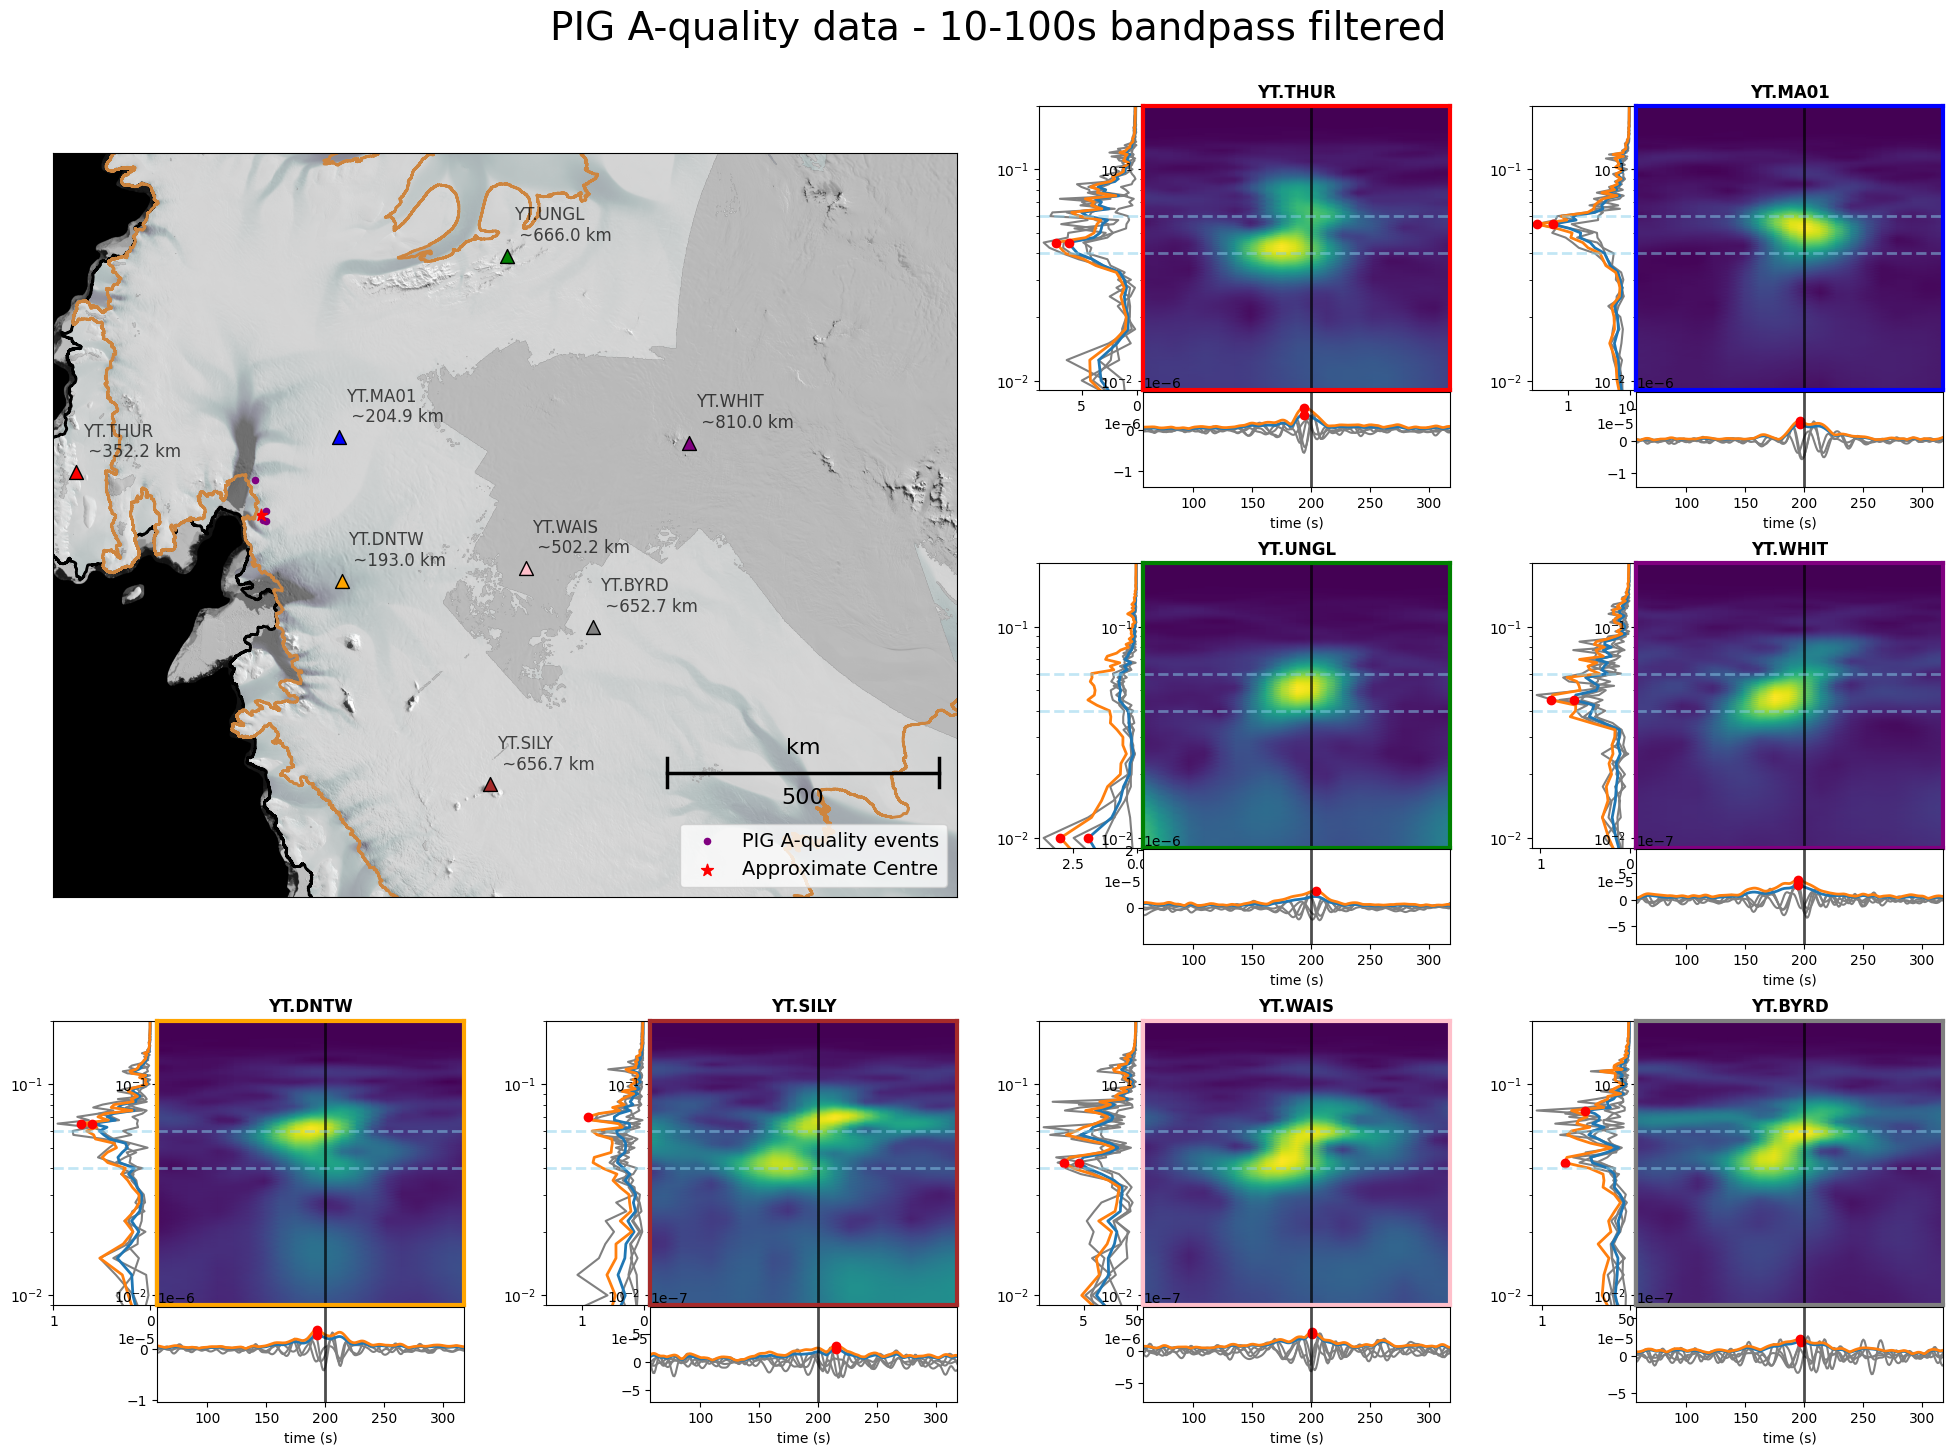

In [23]:
PIG_aqual_inv2_plot = inv2_plotter('PIG_aqual', savefig=True) # add overlay of the 4 quarters around NSEW, or orientation of SF force vector? to show like the lobes pattern maybe
# also have to make it a better map lmao this is a bit of a placeholder


C:\Users\thele\AppData\Local\Temp\ipykernel_16768\2111524989.py:34: RuntimeWarning: invalid value encountered in divide
  envelope_norm = envelope / np.max(envelope)  # normalising the envelope
C:\Users\thele\AppData\Local\Temp\ipykernel_16768\2111524989.py:90: RuntimeWarning: invalid value encountered in divide
  fft_norm = fft / np.max(np.abs(fft))  # normalize


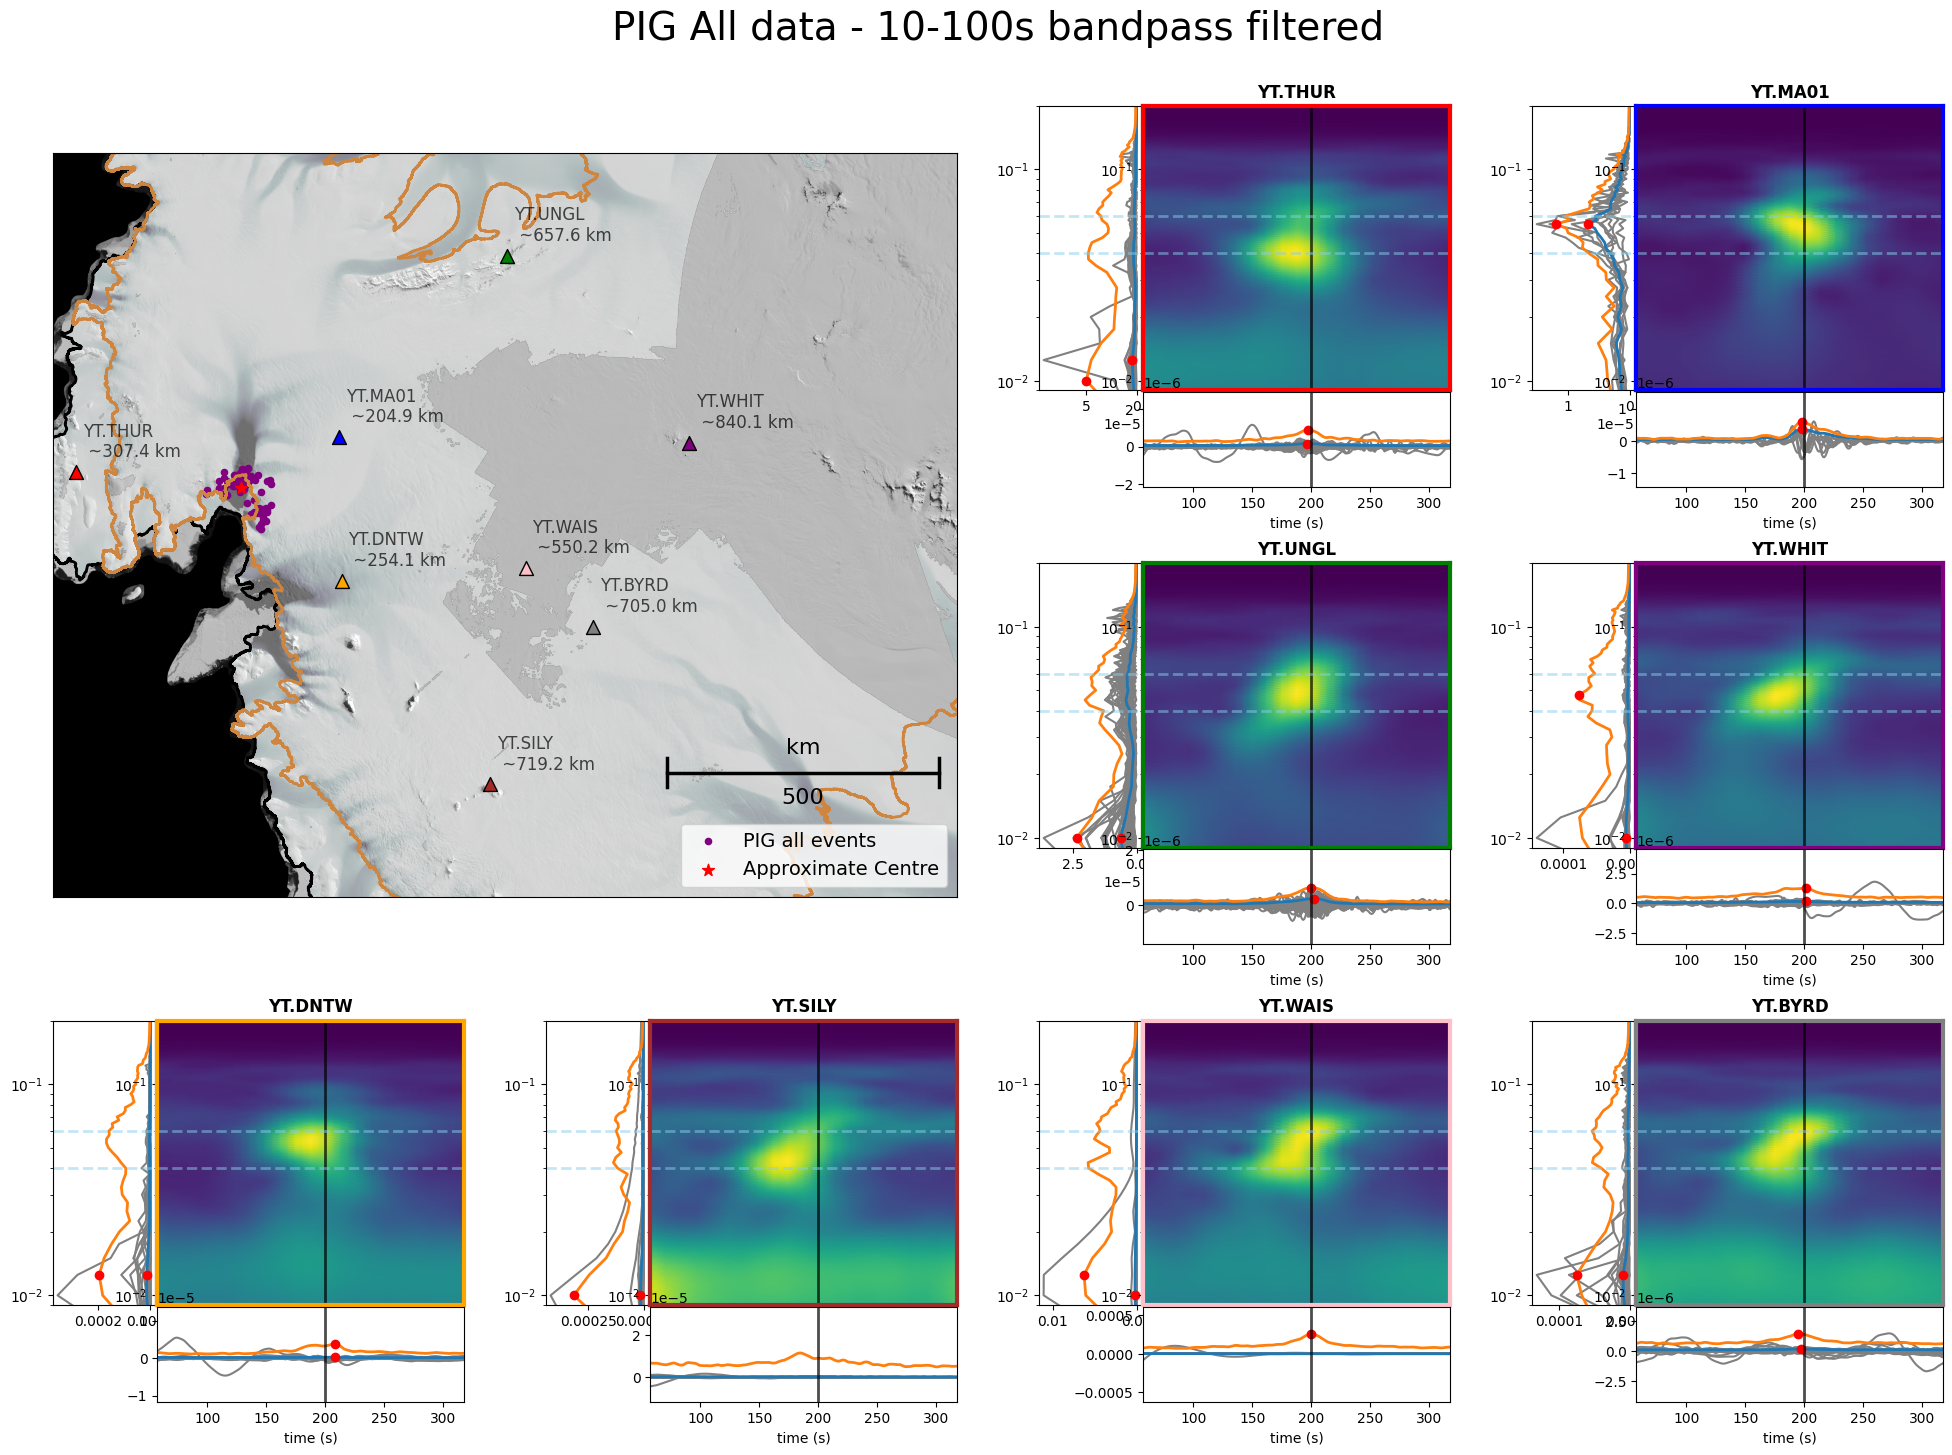

In [24]:
PIG_all_inv2_plot = inv2_plotter('PIG_all', savefig=True)

C:\Users\thele\AppData\Local\Temp\ipykernel_38868\2111524989.py:34: RuntimeWarning: invalid value encountered in divide
  envelope_norm = envelope / np.max(envelope)  # normalising the envelope
C:\Users\thele\AppData\Local\Temp\ipykernel_38868\2111524989.py:90: RuntimeWarning: invalid value encountered in divide
  fft_norm = fft / np.max(np.abs(fft))  # normalize


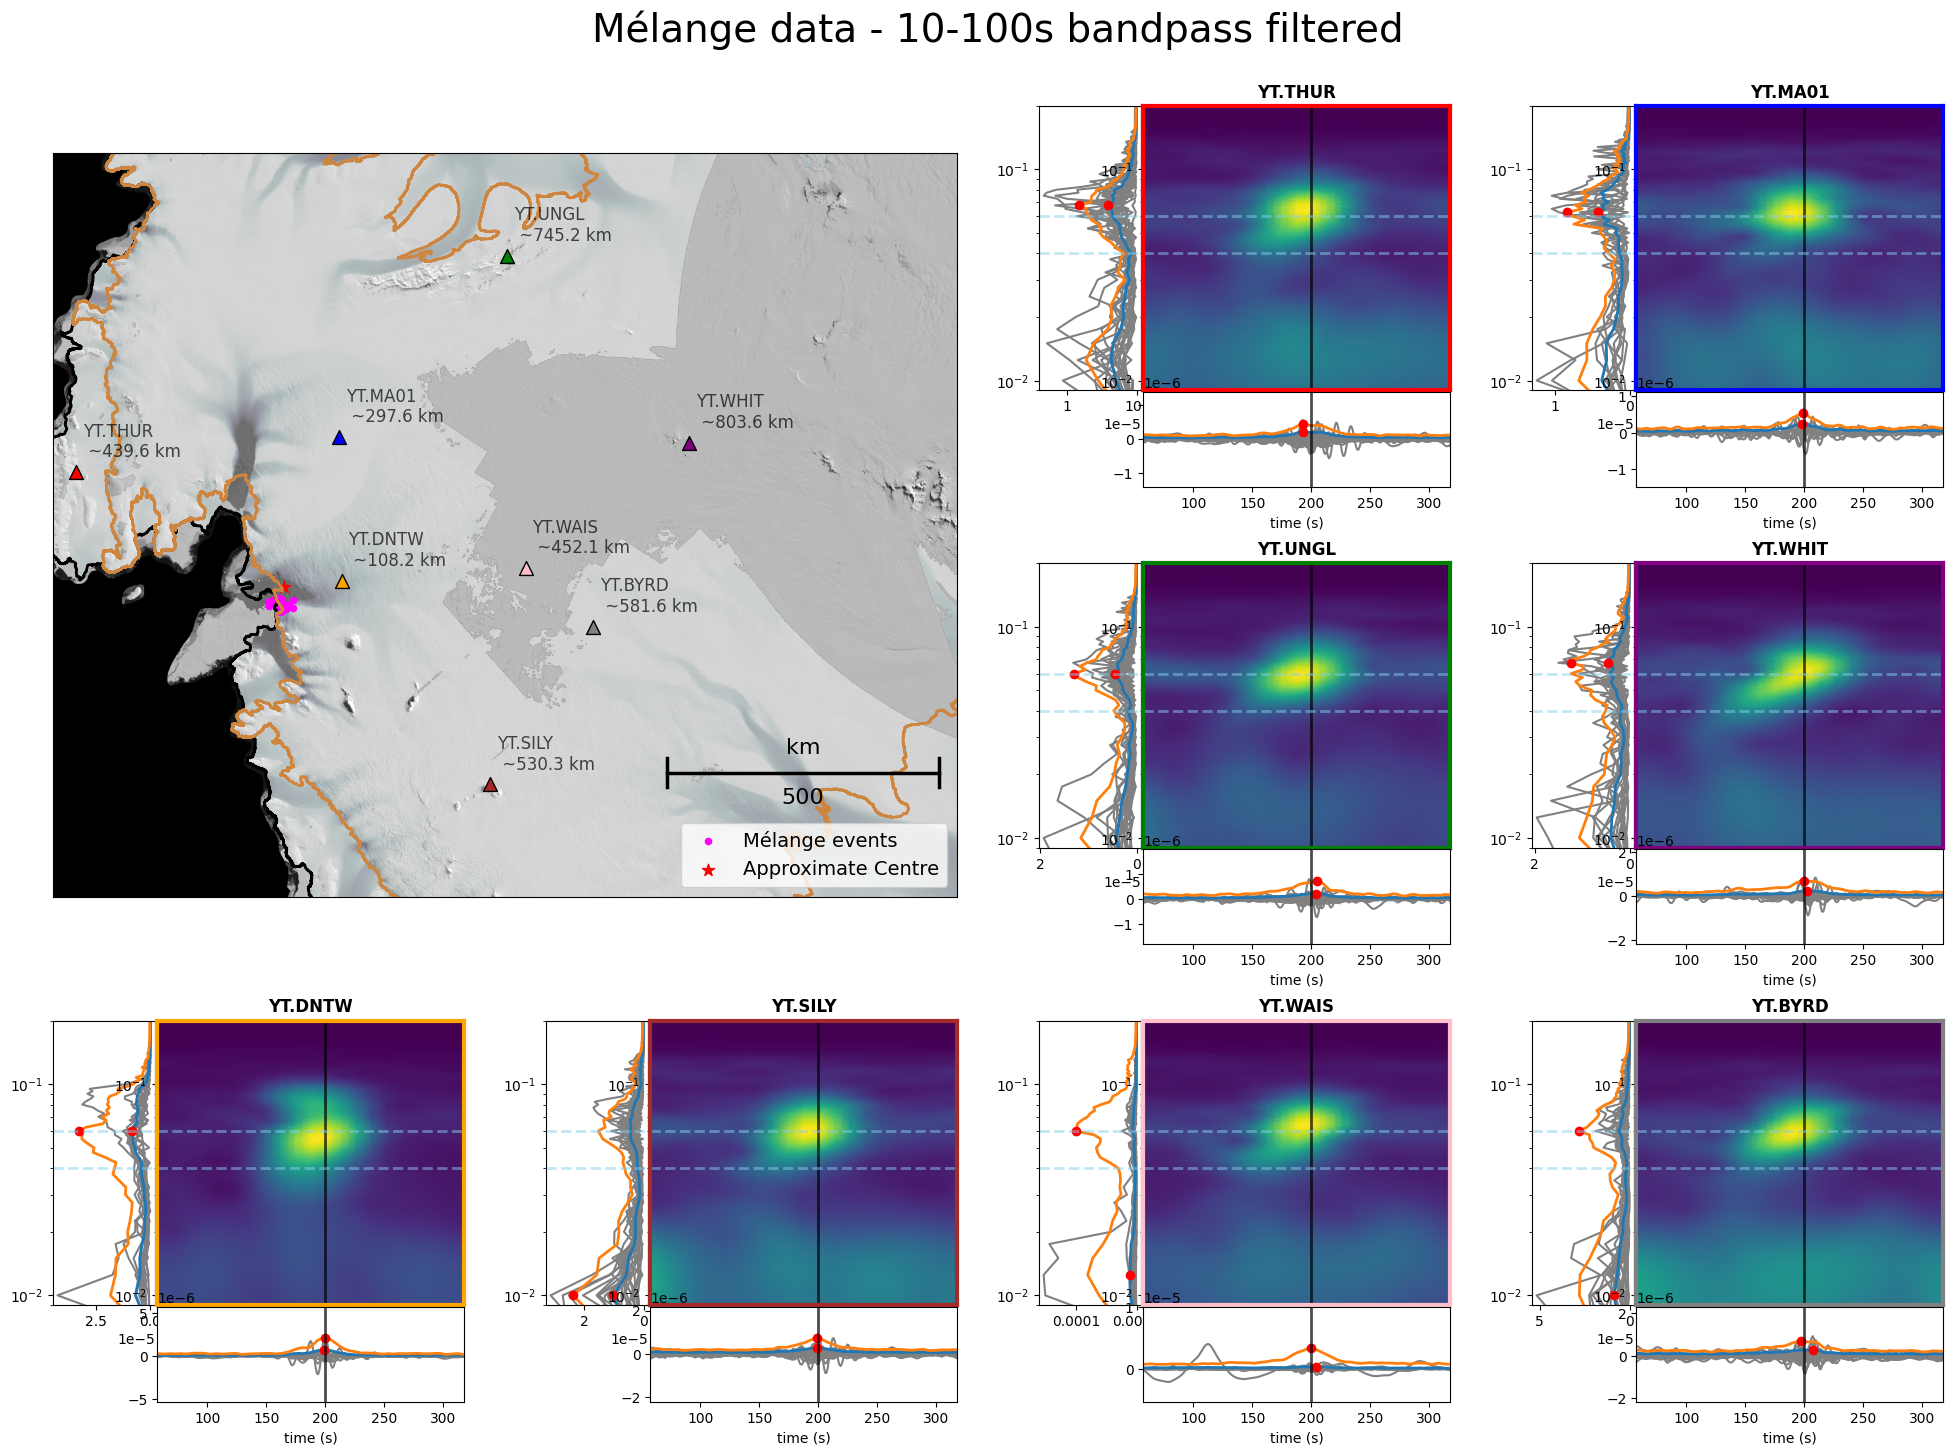

In [22]:
Mel_inv2_plot = inv2_plotter('Mel', savefig=True)

In [23]:
ssep_Ton['THUR']

18 Trace(s) in Stream:
YT.THUR..LHZ | 2011-05-08T16:32:56.999998Z - 2011-05-08T16:39:35.999998Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2013-06-17T15:40:05.000000Z - 2013-06-17T15:46:44.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-01-28T08:56:04.000000Z - 2016-01-28T09:02:43.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-02-11T08:56:00.000000Z - 2016-02-11T09:02:39.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-03-03T05:23:18.000001Z - 2016-03-03T05:29:57.000001Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-08-09T03:58:54.000000Z - 2016-08-09T04:05:33.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-10-20T17:47:31.000001Z - 2016-10-20T17:54:10.000001Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-11-11T08:19:45.000000Z - 2016-11-11T08:26:24.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-11-17T01:47:32.000000Z - 2016-11-17T01:54:11.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-11-24T10:07:05.000000Z - 2016-11-24T10:13:44.000000Z | 1.0 Hz, 400 samples
YT.THUR..LHZ | 2016-12-08T0

C:\Users\thele\AppData\Local\Temp\ipykernel_38868\2111524989.py:34: RuntimeWarning: invalid value encountered in divide
  envelope_norm = envelope / np.max(envelope)  # normalising the envelope
C:\Users\thele\AppData\Local\Temp\ipykernel_38868\2111524989.py:90: RuntimeWarning: invalid value encountered in divide
  fft_norm = fft / np.max(np.abs(fft))  # normalize


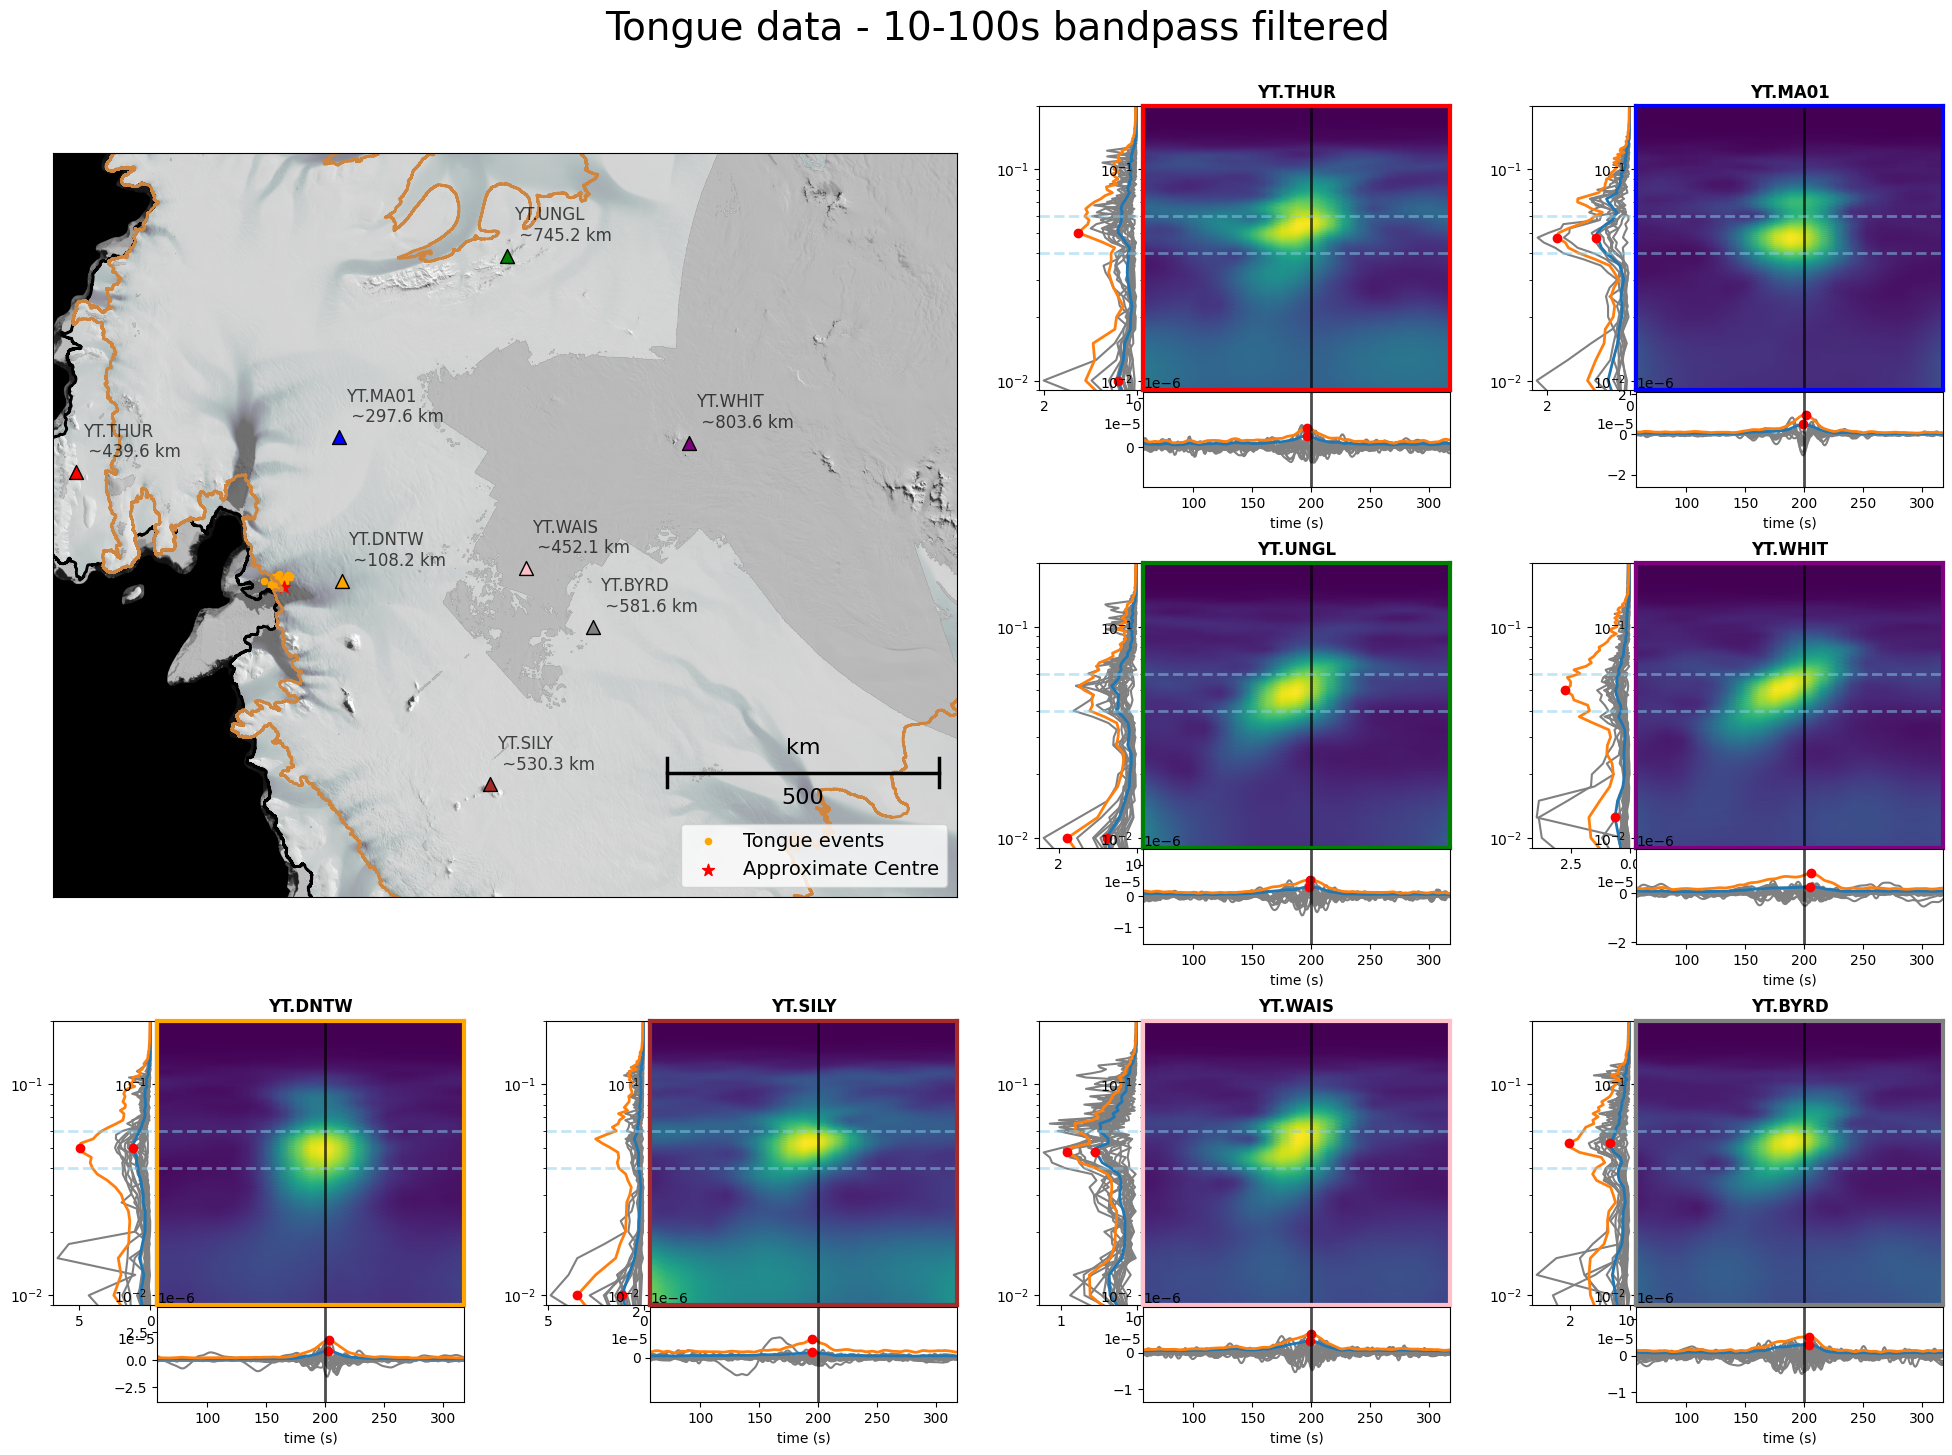

In [24]:
Ton_inv2_plot = inv2_plotter('Ton', savefig=True)